In [1]:
import sys
# !{sys.executable} -m pip install Ripser Cython
from glob import glob
import numpy as np
import joblib
import os
import pandas as pd
import json

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from tqdm.notebook import tqdm
import seaborn as sns
from collections import Counter
from Element_PI import VariancePersistv1
# SHAP
import shap

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
# pixelsx = 150 # Don't make too large 150
# pixelsy = 150 # 150
pixelsx = 4 # Don't make too large 150
pixelsy = 4 # 150
spread = 0.06
Max = 2.5 # 2.5



In [3]:
existsY=joblib.load("/Users/grierjones/qregress/database/processed/intermediate/BSE49_existing.bin")['BSE']
hypoY=joblib.load("/Users/grierjones/qregress/database/processed/intermediate/BSE49_Hypothetical.bin")['BSE']

In [4]:
X=np.zeros((len(existsY)+len(hypoY),(pixelsx*pixelsy)))
y=np.zeros((len(existsY)+len(hypoY),))

In [5]:
overIDX=0
for idx,i in enumerate(pd.read_csv('/Users/grierjones/qregress/database/processed/intermediate/existing_molsA.csv')['XYZ']):
    # print(existsY.loc[idx],os.path.basename(i).replace('_A.xyz',''))
    B=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Existing/{os.path.basename(i).replace('_A.xyz','_B.xyz')}"
    A=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Existing/{os.path.basename(i)}"
    AB=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Existing/{os.path.basename(i).replace('_A.xyz','_AB.xyz')}"
    # PI_A=VariancePersistv1(f'{A}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    # PI_B=VariancePersistv1(f'{B}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    PI_AB=VariancePersistv1(f'{AB}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    X[idx,:]=PI_AB
    y[idx]=existsY.loc[idx]
    overIDX+=1
print(overIDX)
for idx,i in enumerate(pd.read_csv('/Users/grierjones/qregress/database/processed/intermediate/hypothetical_molsA.csv')['XYZ']):
    # print(hypoY.loc[idx],os.path.basename(i).replace('_A.xyz',''))
    B=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Hypothetical/{os.path.basename(i).replace('_A.xyz','_B.xyz')}"
    A=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Hypothetical/{os.path.basename(i)}"
    AB=f"/Users/grierjones/qregress/database/bse49-main/Geometries/Hypothetical/{os.path.basename(i).replace('_A.xyz','_AB.xyz')}"
    # PI_A=VariancePersistv1(f'{A}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    # PI_B=VariancePersistv1(f'{B}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    PI_AB=VariancePersistv1(f'{AB}', pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    X[idx,:]=PI_AB
    y[idx]=hypoY.loc[idx]
    overIDX+=1
print(overIDX)

1951
4394


In [6]:
X.shape

(4394, 16)

In [7]:
trainsize=[ 0.1,0.3, 0.5, 0.7,0.8]

In [8]:


gaussian_kernel = RBF()

models = {
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    'grad': GradientBoostingRegressor(),
    'svr': SVR(),
    'krr': KernelRidge(),
    'gpr': GaussianProcessRegressor()
}

param_grid = {
    'ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
    },
    'knn': {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance']
    },
    'rfr': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'grad': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7]
    },
    'svr': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.01, 0.001]
    },
    'krr': {
        'kernel': ['linear', 'poly', 'rbf'],
        'alpha': [0.001, 0.01, 0.1, 1],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'gpr': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': [gaussian_kernel]
    },
    'lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    'elastic': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000]
    }
}


In [9]:
def gridsearch(model,X_tr, y_tr,X_tst,y_tst):
    """
    Perform GridSearchCV for a given model

    parameters
    ----------
    model: str
        Name of model

    X_tr: np.array
        X training

    y_tr: np.array
        Y Training

    X_tst: np.array
        X test

    y_tst: np.array
        y test

    Returns
    -------
    scores: dict
        scored models
    """
    print(X_tr.shape, y_tr.shape,X_tst.shape,y_tst.shape)
    st = time.time()
    # Grab model and model parameters to perform gridsearchcv
    current_model = models[model]
    current_param_grid = param_grid[model]

    grid_search = GridSearchCV(current_model, current_param_grid, cv=5,n_jobs=-1)

    print(f'Now fitting {model}... ')

    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_

    print(f'Completed fitting {model} in {time.time() - st} seconds. ')

    # Take the best model and evaluate using known metrics
    model=best_model
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    y_tr_pred = model.predict(X_tr)
    y_tst_pred = model.predict(X_tst)

    plt.scatter(y_tr,y_tr_pred)
    plt.scatter(y_tst,y_tst_pred)
    plt.scatter(y_tr, y_tr)
    plt.scatter(y_tst,y_tst)
    plt.show()
            
    scores['MSE_train'] = mean_squared_error(y_tr, y_tr_pred),
    scores['R2_train'] = r2_score(y_tr, y_tr_pred)
    scores['MAE_train'] = mean_absolute_error(y_tr, y_tr_pred)
    scores['MSE_test'] = mean_squared_error(y_tst, y_tst_pred)
    scores['R2_test'] = r2_score(y_tst, y_tst_pred)
    scores['MAE_test'] = mean_absolute_error(y_tst, y_tst_pred)

    return scores, best_model



(439, 16) (439,) (3955, 16) (3955,)
Now fitting ridge... 
Completed fitting ridge in 0.6338851451873779 seconds. 
Now scoring model... 


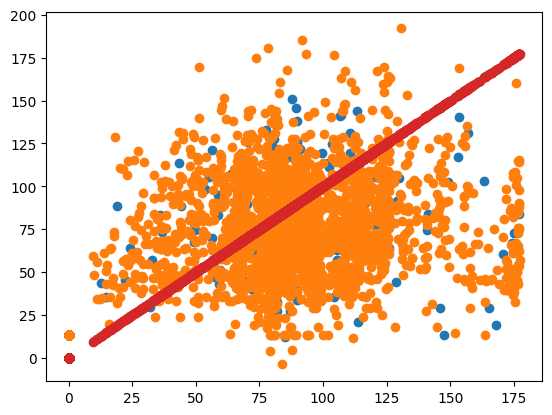

0.1 {'MSE_train': (1021.3257953788415,), 'R2_train': 0.5990765498451331, 'MAE_train': 23.76331666802247, 'MSE_test': 1129.9439402122823, 'R2_test': 0.5690253022331296, 'MAE_test': 24.858664465655263}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting ridge... 
Completed fitting ridge in 0.0970618724822998 seconds. 
Now scoring model... 


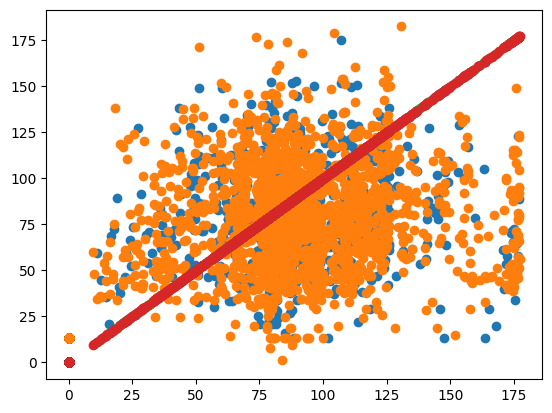

0.3 {'MSE_train': (1022.0019686666503,), 'R2_train': 0.5953099345803661, 'MAE_train': 24.029807673419636, 'MSE_test': 1135.6818120769306, 'R2_test': 0.5716822293361415, 'MAE_test': 24.993823394915086}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting ridge... 
Completed fitting ridge in 0.04355931282043457 seconds. 
Now scoring model... 


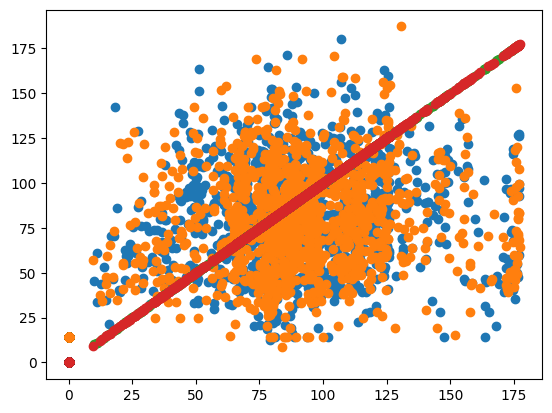

0.5 {'MSE_train': (1074.0693891944134,), 'R2_train': 0.5880697942101876, 'MAE_train': 24.565537398028386, 'MSE_test': 1124.4539573438453, 'R2_test': 0.5710708549812646, 'MAE_test': 25.163114845236013}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting ridge... 
Completed fitting ridge in 0.05493307113647461 seconds. 
Now scoring model... 


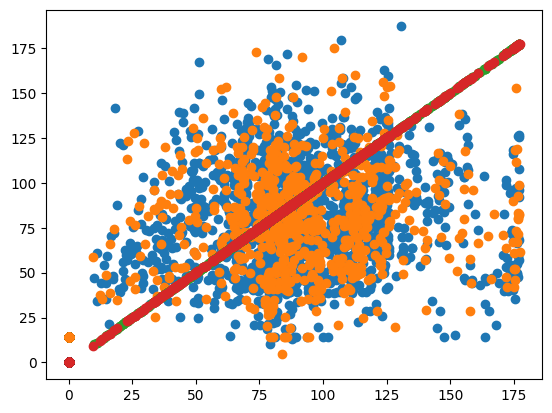

0.7 {'MSE_train': (1070.769507746414,), 'R2_train': 0.5873188959425141, 'MAE_train': 24.554857723703627, 'MSE_test': 1160.9816796162067, 'R2_test': 0.5630302154521581, 'MAE_test': 25.61010175562827}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting ridge... 
Completed fitting ridge in 0.0746917724609375 seconds. 
Now scoring model... 


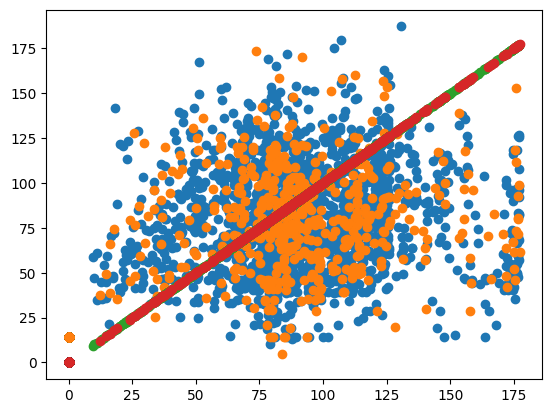

0.8 {'MSE_train': (1075.2916664277661,), 'R2_train': 0.5861534195464168, 'MAE_train': 24.666702652882417, 'MSE_test': 1187.2946204459572, 'R2_test': 0.5565353407166607, 'MAE_test': 25.988722927796516}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting lasso... 
Completed fitting lasso in 0.07030725479125977 seconds. 
Now scoring model... 


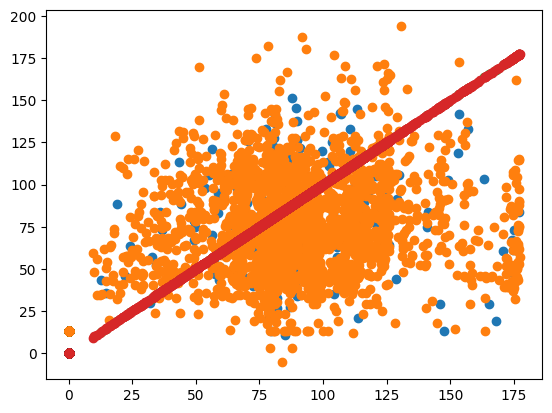

0.1 {'MSE_train': (1021.049803252,), 'R2_train': 0.5991848910974638, 'MAE_train': 23.7496159576466, 'MSE_test': 1132.1657834065186, 'R2_test': 0.5681778635549405, 'MAE_test': 24.87529811651629}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting lasso... 
Completed fitting lasso in 0.05610227584838867 seconds. 
Now scoring model... 


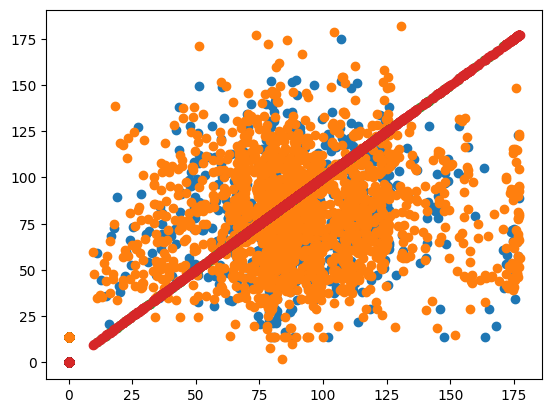

0.3 {'MSE_train': (1022.0775321158535,), 'R2_train': 0.5952800131338926, 'MAE_train': 24.042321777270363, 'MSE_test': 1135.4319667230313, 'R2_test': 0.5717764574939361, 'MAE_test': 24.998612675374737}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting lasso... 
Completed fitting lasso in 0.054080963134765625 seconds. 
Now scoring model... 


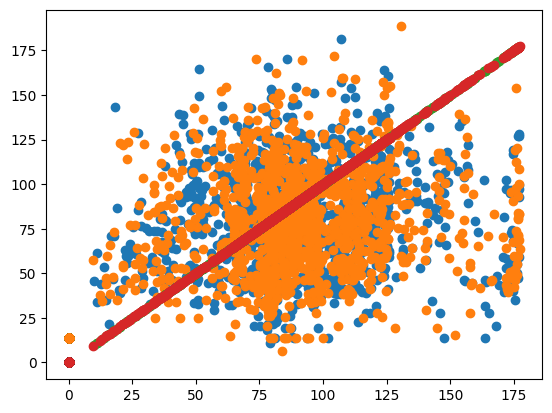

0.5 {'MSE_train': (1073.7274547501095,), 'R2_train': 0.5882009338995091, 'MAE_train': 24.547911351412722, 'MSE_test': 1124.130558649305, 'R2_test': 0.5711942171915565, 'MAE_test': 25.136839099129855}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting lasso... 
Completed fitting lasso in 0.06746888160705566 seconds. 
Now scoring model... 


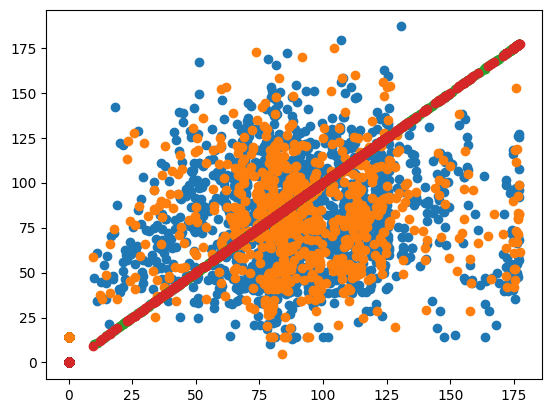

0.7 {'MSE_train': (1070.7809319442088,), 'R2_train': 0.5873144929869529, 'MAE_train': 24.55803376934388, 'MSE_test': 1160.9583663463432, 'R2_test': 0.5630389900906285, 'MAE_test': 25.61192095968127}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting lasso... 
Completed fitting lasso in 0.07832098007202148 seconds. 
Now scoring model... 


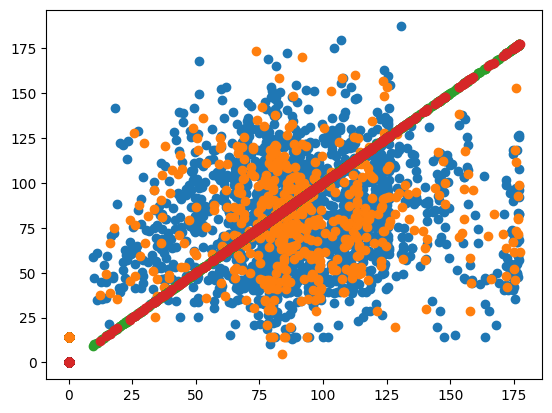

0.8 {'MSE_train': (1075.3051638887928,), 'R2_train': 0.5861482247901798, 'MAE_train': 24.670437261393563, 'MSE_test': 1187.2581748801988, 'R2_test': 0.5565489534460735, 'MAE_test': 25.991811060329777}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting elastic... 
Completed fitting elastic in 0.07481098175048828 seconds. 
Now scoring model... 


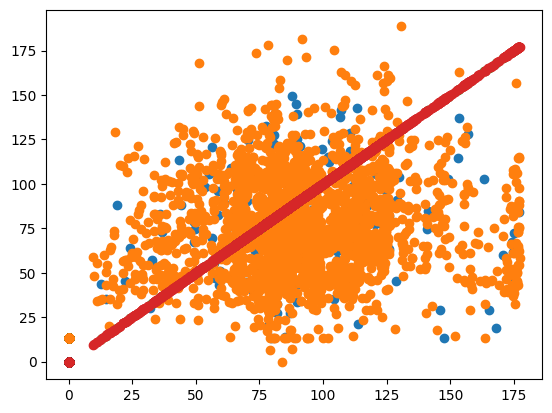

0.1 {'MSE_train': (1022.5350627019739,), 'R2_train': 0.5986018495785352, 'MAE_train': 23.814080844353132, 'MSE_test': 1126.0775172677947, 'R2_test': 0.5705000041193368, 'MAE_test': 24.839068772705687}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting elastic... 
Completed fitting elastic in 0.11081886291503906 seconds. 
Now scoring model... 


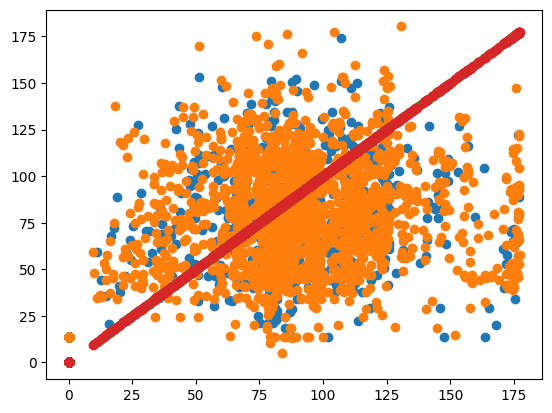

0.3 {'MSE_train': (1022.7410259369943,), 'R2_train': 0.5950172843269869, 'MAE_train': 24.068388680250017, 'MSE_test': 1134.5701117322258, 'R2_test': 0.5721015025940441, 'MAE_test': 25.012953343710162}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting elastic... 
Completed fitting elastic in 0.08036994934082031 seconds. 
Now scoring model... 


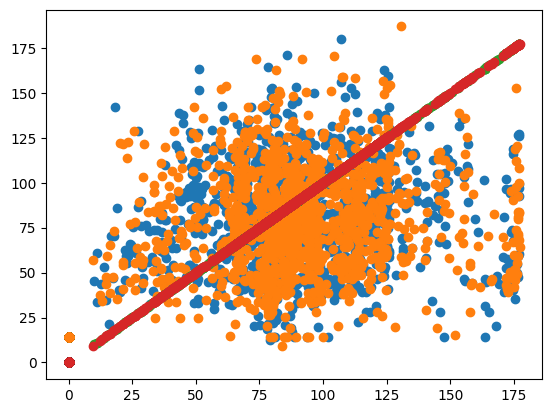

0.5 {'MSE_train': (1074.1870403059422,), 'R2_train': 0.5880246723148322, 'MAE_train': 24.569319157072457, 'MSE_test': 1124.5831497698962, 'R2_test': 0.5710215738199623, 'MAE_test': 25.168686279859312}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting elastic... 
Completed fitting elastic in 0.11839008331298828 seconds. 
Now scoring model... 


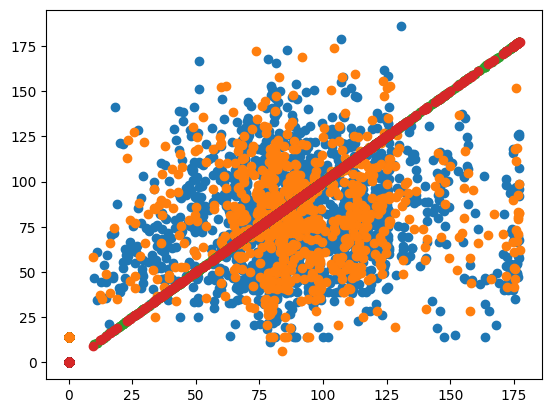

0.7 {'MSE_train': (1071.1103875967324,), 'R2_train': 0.5871875187675362, 'MAE_train': 24.581833058064657, 'MSE_test': 1160.8844961801476, 'R2_test': 0.5630667933119659, 'MAE_test': 25.632821590205985}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting elastic... 
Completed fitting elastic in 0.10137796401977539 seconds. 
Now scoring model... 


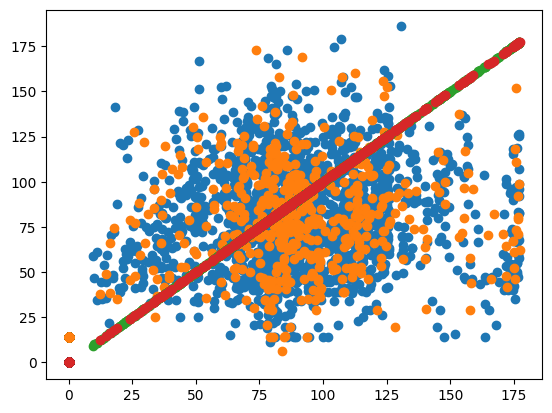

0.8 {'MSE_train': (1075.618913542788,), 'R2_train': 0.5860274722302201, 'MAE_train': 24.691139672034847, 'MSE_test': 1187.038877450117, 'R2_test': 0.5566308629051396, 'MAE_test': 26.025303943769494}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting knn... 
Completed fitting knn in 0.10150671005249023 seconds. 
Now scoring model... 


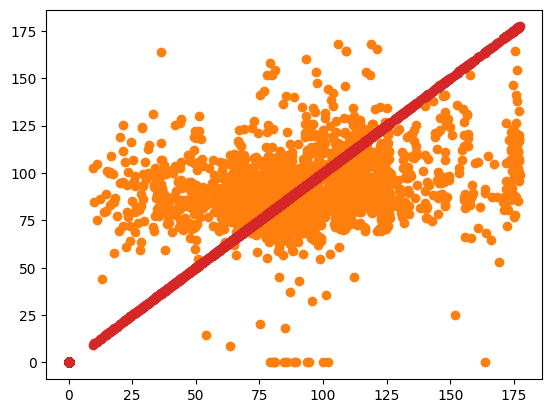

0.1 {'MSE_train': (0.06611799563120654,), 'R2_train': 0.999974045250746, 'MAE_train': 0.02291742207114835, 'MSE_test': 576.6304299635457, 'R2_test': 0.7800659692638986, 'MAE_test': 13.297786184545764}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting knn... 
Completed fitting knn in 0.06216716766357422 seconds. 
Now scoring model... 


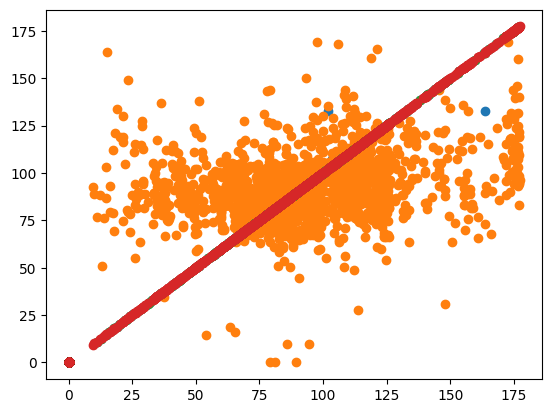

0.3 {'MSE_train': (1.7267619508761438,), 'R2_train': 0.9993162406450392, 'MAE_train': 0.08709788602442091, 'MSE_test': 566.7507613570731, 'R2_test': 0.7862522582953346, 'MAE_test': 13.095459491659565}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting knn... 
Completed fitting knn in 0.08906817436218262 seconds. 
Now scoring model... 


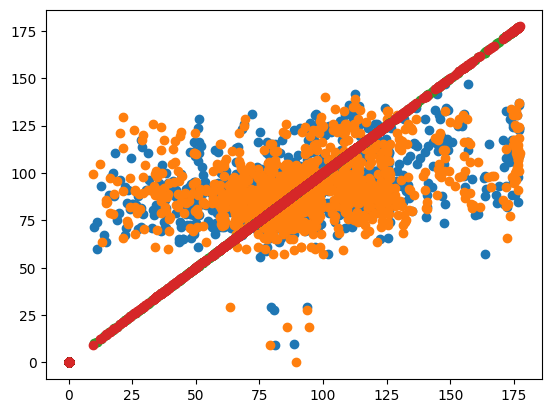

0.5 {'MSE_train': (438.4323605741837,), 'R2_train': 0.8318511500903165, 'MAE_train': 11.57580791989076, 'MSE_test': 517.2625346325236, 'R2_test': 0.8026873619136481, 'MAE_test': 12.630358569766853}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting knn... 
Completed fitting knn in 0.09977889060974121 seconds. 
Now scoring model... 


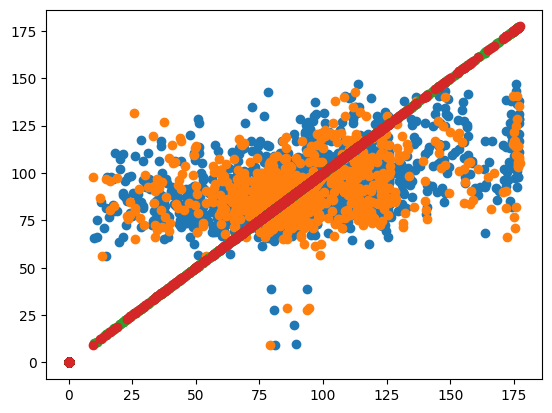

0.7 {'MSE_train': (415.9308262671886,), 'R2_train': 0.8396977207945147, 'MAE_train': 11.205788979223126, 'MSE_test': 527.8754655827928, 'R2_test': 0.8013184596159542, 'MAE_test': 13.029520680650323}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting knn... 
Completed fitting knn in 0.11217308044433594 seconds. 
Now scoring model... 


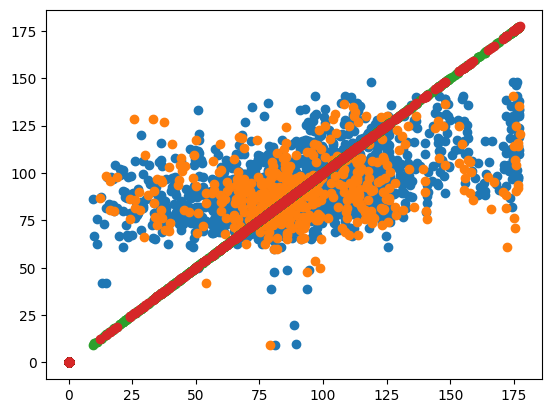

0.8 {'MSE_train': (398.53294406406405,), 'R2_train': 0.8466169679832709, 'MAE_train': 11.113387703492966, 'MSE_test': 588.6800052304105, 'R2_test': 0.7801230011061933, 'MAE_test': 13.570615598533688}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting rfr... 
Completed fitting rfr in 1.491091012954712 seconds. 
Now scoring model... 


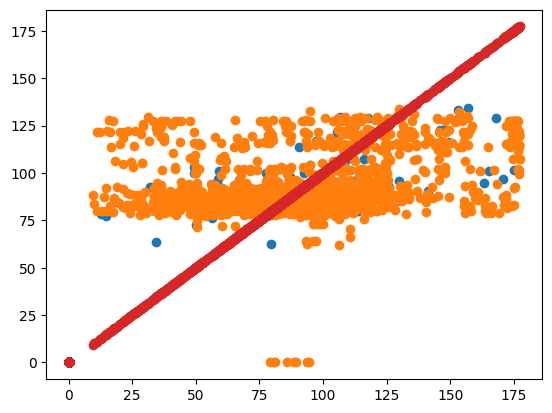

0.1 {'MSE_train': (312.25712278514413,), 'R2_train': 0.8774228521702866, 'MAE_train': 9.361337346347012, 'MSE_test': 507.38183950581384, 'R2_test': 0.8064782444938502, 'MAE_test': 12.17715084016889}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting rfr... 
Completed fitting rfr in 2.614647150039673 seconds. 
Now scoring model... 


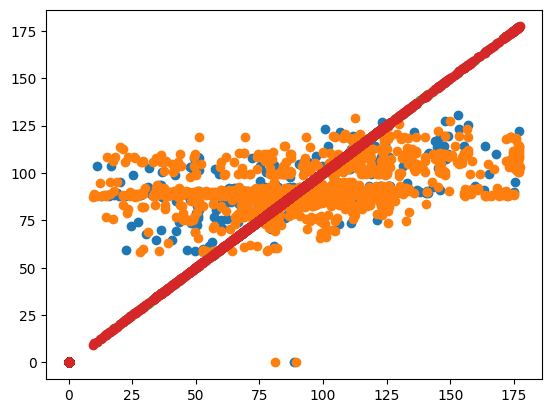

0.3 {'MSE_train': (381.90934754032406,), 'R2_train': 0.8487723863760236, 'MAE_train': 10.49549107799165, 'MSE_test': 479.06672828482886, 'R2_test': 0.8193219342987182, 'MAE_test': 12.023112063204438}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting rfr... 
Completed fitting rfr in 3.827219009399414 seconds. 
Now scoring model... 


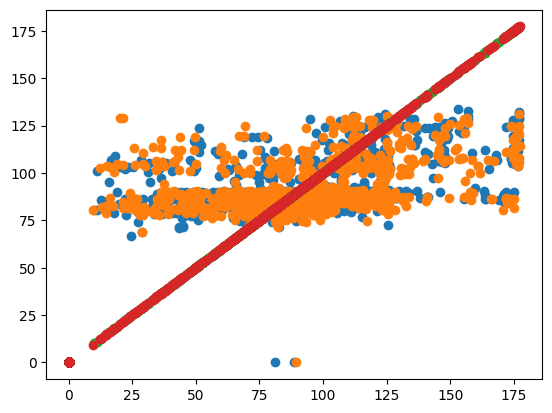

0.5 {'MSE_train': (412.75742494559427,), 'R2_train': 0.8416980758322908, 'MAE_train': 10.947220420268268, 'MSE_test': 448.4502347890785, 'R2_test': 0.8289361920643665, 'MAE_test': 11.490628535252418}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting rfr... 
Completed fitting rfr in 5.3242223262786865 seconds. 
Now scoring model... 


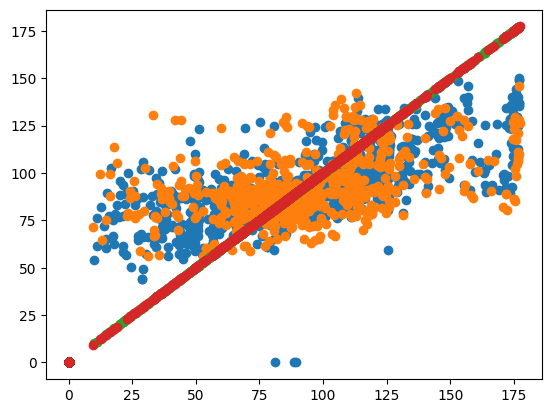

0.7 {'MSE_train': (289.0945650665606,), 'R2_train': 0.8885811900454853, 'MAE_train': 9.023384172939153, 'MSE_test': 443.6560454636953, 'R2_test': 0.8330169286877073, 'MAE_test': 11.648725166868369}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting rfr... 
Completed fitting rfr in 5.970273017883301 seconds. 
Now scoring model... 


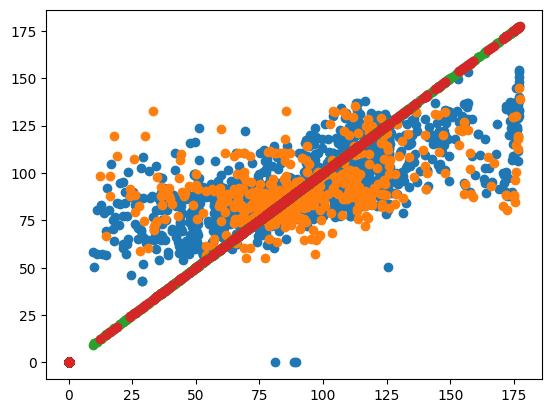

0.8 {'MSE_train': (283.4739179937976,), 'R2_train': 0.8908996365616366, 'MAE_train': 8.96974936435965, 'MSE_test': 487.37779420621354, 'R2_test': 0.8179602402571806, 'MAE_test': 12.038317470239354}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting grad... 
Completed fitting grad in 0.9529018402099609 seconds. 
Now scoring model... 


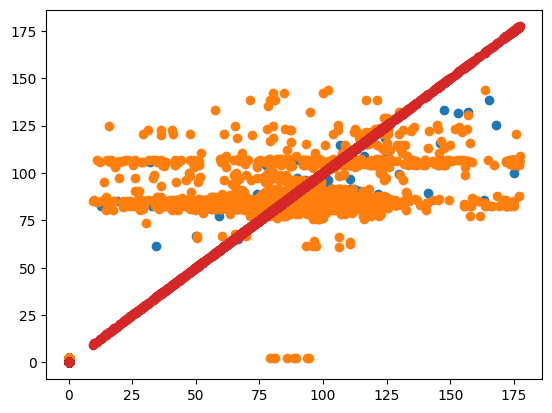

0.1 {'MSE_train': (338.8719565458094,), 'R2_train': 0.8669751468201381, 'MAE_train': 10.428994809482578, 'MSE_test': 523.9574616990639, 'R2_test': 0.8001560956590225, 'MAE_test': 13.48512380828211}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting grad... 
Completed fitting grad in 1.8895368576049805 seconds. 
Now scoring model... 


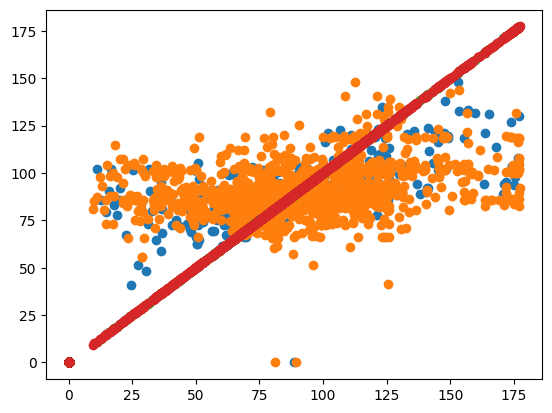

0.3 {'MSE_train': (314.88198083304235,), 'R2_train': 0.8753137338971684, 'MAE_train': 9.462837257179055, 'MSE_test': 493.12032041690736, 'R2_test': 0.8140216792556065, 'MAE_test': 12.347126882164345}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting grad... 
Completed fitting grad in 2.9816958904266357 seconds. 
Now scoring model... 


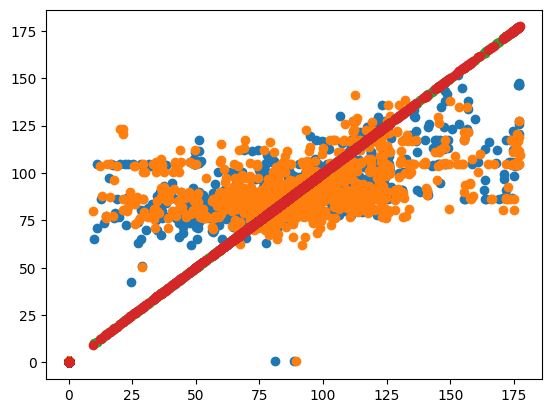

0.5 {'MSE_train': (367.4713267291782,), 'R2_train': 0.8590663315012264, 'MAE_train': 10.284009174947535, 'MSE_test': 448.4478568774361, 'R2_test': 0.8289370991318379, 'MAE_test': 11.570537993080219}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting grad... 
Completed fitting grad in 4.132651090621948 seconds. 
Now scoring model... 


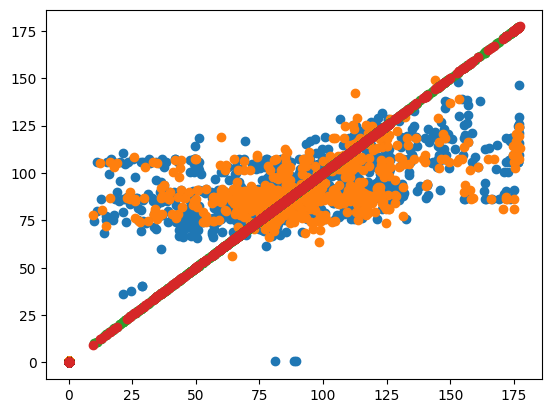

0.7 {'MSE_train': (377.0772450761053,), 'R2_train': 0.8546721281403771, 'MAE_train': 10.381146584144856, 'MSE_test': 447.3093586220216, 'R2_test': 0.831641896254631, 'MAE_test': 11.790186217183011}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting grad... 
Completed fitting grad in 5.307146787643433 seconds. 
Now scoring model... 


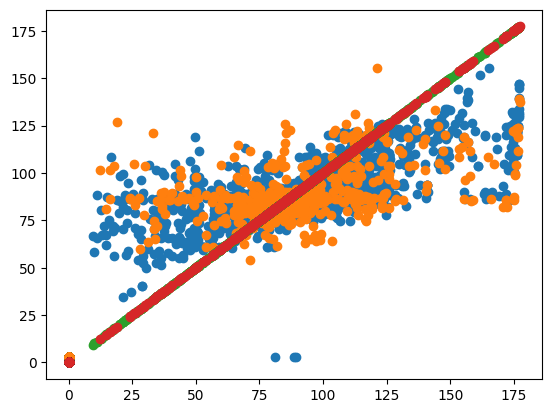

0.8 {'MSE_train': (288.366515077124,), 'R2_train': 0.8890166269227744, 'MAE_train': 10.045768638137968, 'MSE_test': 480.21913752334746, 'R2_test': 0.8206340595368479, 'MAE_test': 13.045985397104008}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting svr... 
Completed fitting svr in 0.0652778148651123 seconds. 
Now scoring model... 


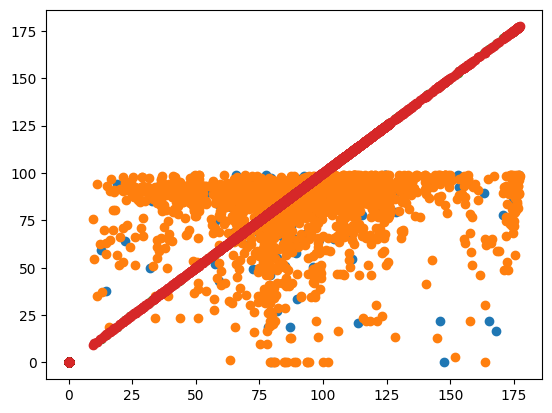

0.1 {'MSE_train': (669.7768441394587,), 'R2_train': 0.7370777822304739, 'MAE_train': 13.144223420962364, 'MSE_test': 682.6212088158804, 'R2_test': 0.739639765576857, 'MAE_test': 14.518303257159232}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting svr... 
Completed fitting svr in 0.31099796295166016 seconds. 
Now scoring model... 


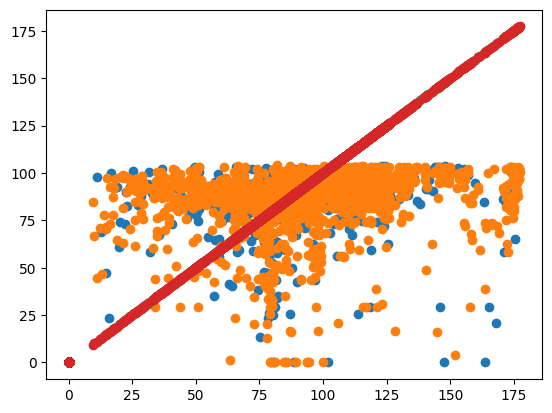

0.3 {'MSE_train': (578.5344618431075,), 'R2_train': 0.7709132111396492, 'MAE_train': 12.86499725321885, 'MSE_test': 629.7328138988007, 'R2_test': 0.762498833656815, 'MAE_test': 13.862984554205374}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting svr... 
Completed fitting svr in 0.773719072341919 seconds. 
Now scoring model... 


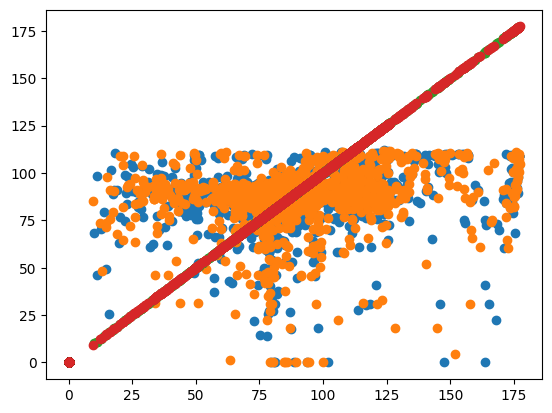

0.5 {'MSE_train': (591.3320837179707,), 'R2_train': 0.7732106050254716, 'MAE_train': 13.067507428084008, 'MSE_test': 595.0025451501537, 'R2_test': 0.7730330074358168, 'MAE_test': 13.402551951349848}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting svr... 
Completed fitting svr in 1.5758581161499023 seconds. 
Now scoring model... 


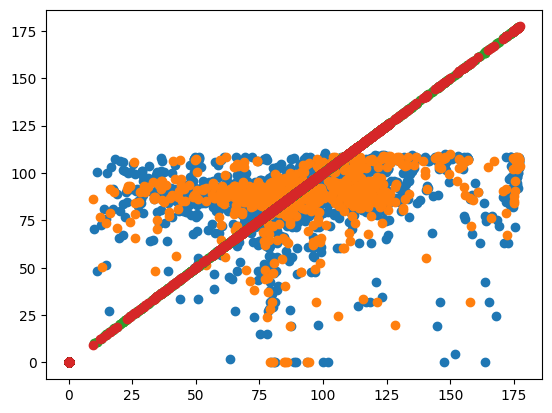

0.7 {'MSE_train': (578.9935948778196,), 'R2_train': 0.7768523344680651, 'MAE_train': 12.847884139917086, 'MSE_test': 595.9518647974592, 'R2_test': 0.7756958937995329, 'MAE_test': 13.726928008898641}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting svr... 
Completed fitting svr in 1.811995029449463 seconds. 
Now scoring model... 


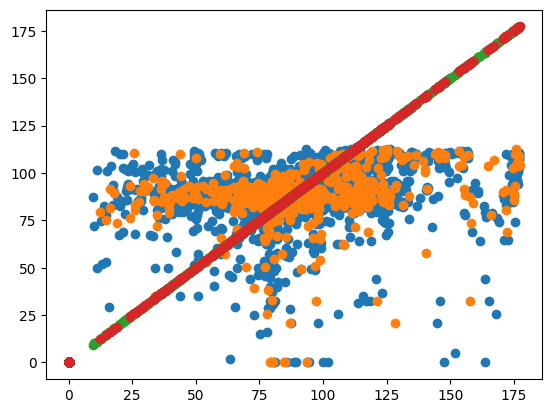

0.8 {'MSE_train': (565.7974898836859,), 'R2_train': 0.7822420058406416, 'MAE_train': 12.791935533777886, 'MSE_test': 623.2934238027275, 'R2_test': 0.7671945942815765, 'MAE_test': 13.885066382059929}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting krr... 
Completed fitting krr in 0.3968667984008789 seconds. 
Now scoring model... 


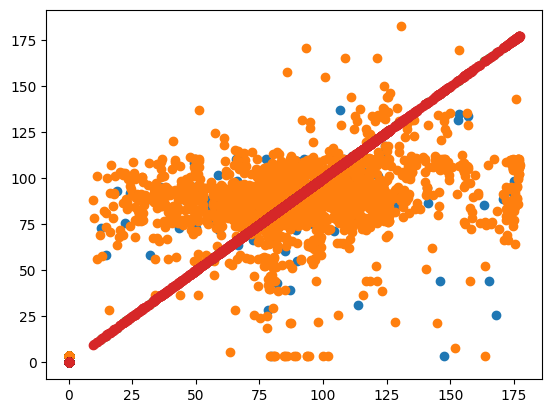

0.1 {'MSE_train': (549.2768874144125,), 'R2_train': 0.7843802772935673, 'MAE_train': 13.133858024896071, 'MSE_test': 587.0283164041426, 'R2_test': 0.7761000858190008, 'MAE_test': 14.794816727560743}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting krr... 
Completed fitting krr in 1.1174719333648682 seconds. 
Now scoring model... 


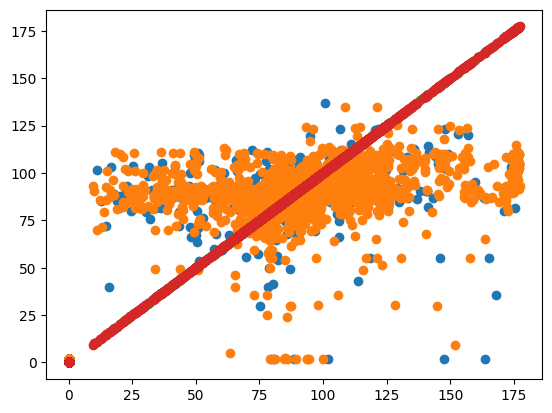

0.3 {'MSE_train': (502.55793338640024,), 'R2_train': 0.8009982278168826, 'MAE_train': 12.547087731172534, 'MSE_test': 558.0489150837269, 'R2_test': 0.7895341241813816, 'MAE_test': 13.692133998737898}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting krr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 3.4691781997680664 seconds. 
Now scoring model... 


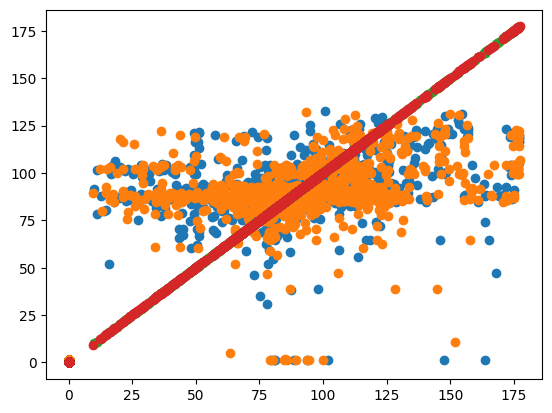

0.5 {'MSE_train': (500.971345241991,), 'R2_train': 0.8078660173947299, 'MAE_train': 12.425982259088954, 'MSE_test': 527.1337028309046, 'R2_test': 0.7989219505261785, 'MAE_test': 12.866839897095119}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting krr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 7.243546009063721 seconds. 
Now scoring model... 


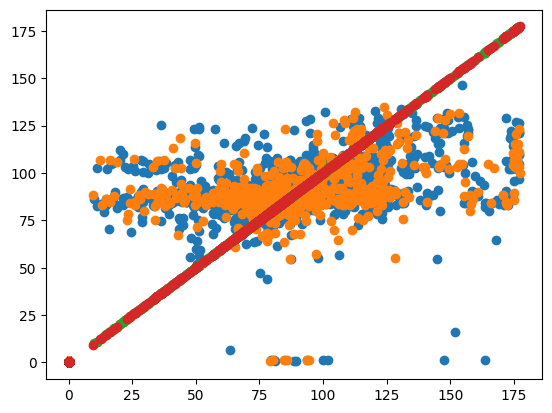

0.7 {'MSE_train': (483.17042840697616,), 'R2_train': 0.8137831677121858, 'MAE_train': 11.897087065433034, 'MSE_test': 522.4160553716038, 'R2_test': 0.8033732700799145, 'MAE_test': 12.947423236461022}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting krr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 9.42324686050415 seconds. 
Now scoring model... 


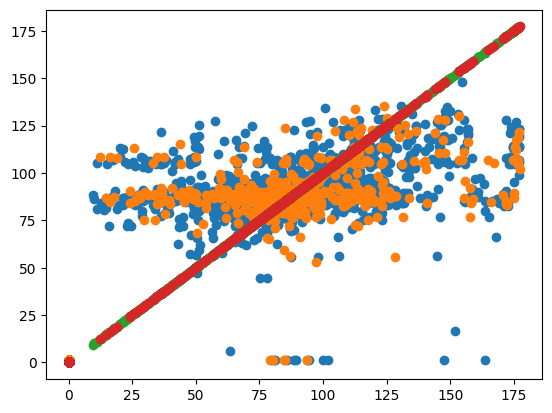

0.8 {'MSE_train': (476.32961123313294,), 'R2_train': 0.8166754314831668, 'MAE_train': 11.8830996726367, 'MSE_test': 561.7289695967263, 'R2_test': 0.7901894426016796, 'MAE_test': 13.33844898941642}
(439, 16) (439,) (3955, 16) (3955,)
Now fitting gpr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/minicon

Completed fitting gpr in 0.2546267509460449 seconds. 
Now scoring model... 


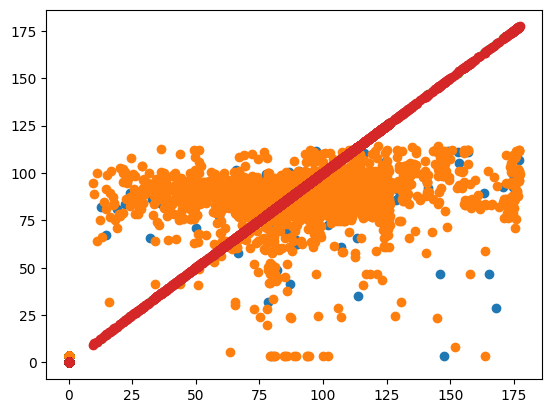

0.1 {'MSE_train': (555.9052964375492,), 'R2_train': 0.7817782822919549, 'MAE_train': 13.444719324329524, 'MSE_test': 594.6746326248518, 'R2_test': 0.7731836855402127, 'MAE_test': 14.789531787342305}
(1318, 16) (1318,) (3076, 16) (3076,)
Now fitting gpr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/minicon

Completed fitting gpr in 1.9976909160614014 seconds. 
Now scoring model... 


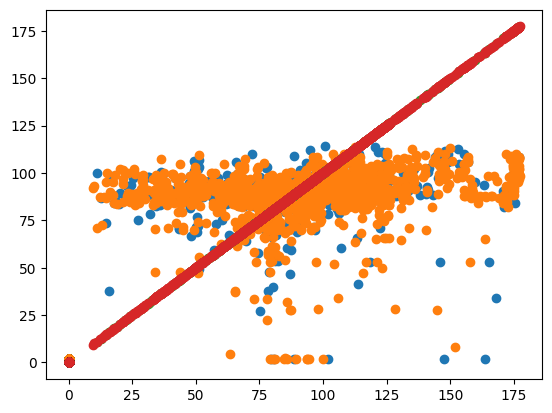

0.3 {'MSE_train': (514.547967975087,), 'R2_train': 0.7962504406003768, 'MAE_train': 12.964462248296009, 'MSE_test': 572.5329113358897, 'R2_test': 0.784071543977086, 'MAE_test': 13.973064746343212}
(2197, 16) (2197,) (2197, 16) (2197,)
Now fitting gpr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/minicon

Completed fitting gpr in 7.5905678272247314 seconds. 
Now scoring model... 


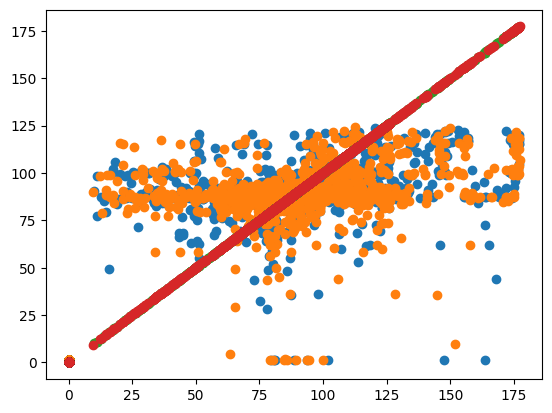

0.5 {'MSE_train': (513.267519334706,), 'R2_train': 0.8031501530610126, 'MAE_train': 12.743322117344855, 'MSE_test': 539.6227797522715, 'R2_test': 0.7941579234613363, 'MAE_test': 13.19587492150981}
(3075, 16) (3075,) (1319, 16) (1319,)
Now fitting gpr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/minicon

Completed fitting gpr in 20.276275873184204 seconds. 
Now scoring model... 


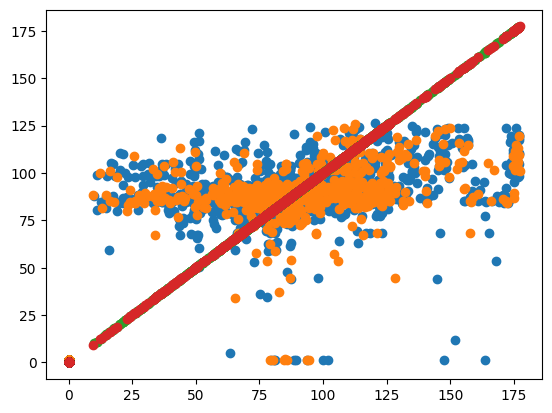

0.7 {'MSE_train': (502.75642461764863,), 'R2_train': 0.8062346052234226, 'MAE_train': 12.44284565176038, 'MSE_test': 535.647648388507, 'R2_test': 0.7983931687989604, 'MAE_test': 13.337557690613274}
(3515, 16) (3515,) (879, 16) (879,)
Now fitting gpr... 


/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/envs/qchem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/minicon

Completed fitting gpr in 29.763227939605713 seconds. 
Now scoring model... 


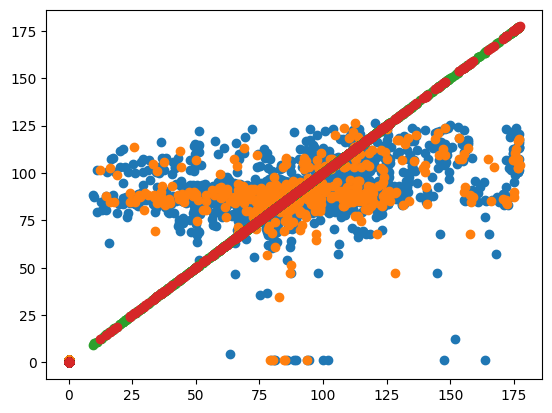

0.8 {'MSE_train': (492.5046259967919,), 'R2_train': 0.810450167438329, 'MAE_train': 12.340965856135078, 'MSE_test': 571.2244198755009, 'R2_test': 0.7866428109989549, 'MAE_test': 13.66186198549034}


In [10]:
performance={}
for m in models:
    performance[m]={}
    for ts in trainsize:
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=ts,random_state=42)
        scores, best_model = gridsearch(m,X_train, y_train,X_test,y_test)
        performance[m][ts]=scores
        print(ts,scores)

In [11]:
dfmelt=[]
for k,v in performance.items():
    df=pd.DataFrame.from_dict(v).loc[['MAE_train','MAE_test']].T
    df.columns=[df.columns,[k,k]]
    dfmelt.append(df.melt(value_vars=df.columns.tolist(),ignore_index=False))
dfmelt=pd.concat(dfmelt)

In [12]:
dfmelt.loc[0.8]

,variable_0,variable_1,value
0.8,MAE_train,ridge,24.666703
0.8,MAE_test,ridge,25.988723
0.8,MAE_train,lasso,24.670437
0.8,MAE_test,lasso,25.991811
0.8,MAE_train,elastic,24.69114
0.8,MAE_test,elastic,26.025304
0.8,MAE_train,knn,11.113388
0.8,MAE_test,knn,13.570616
0.8,MAE_train,rfr,8.969749
0.8,MAE_test,rfr,12.038317


<Axes: xlabel='variable_1', ylabel='value'>

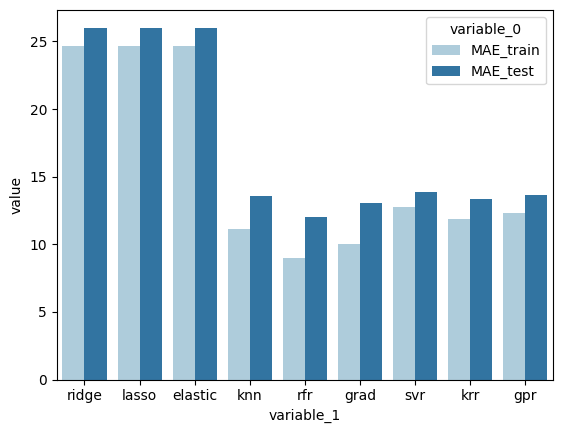

In [13]:
sns.barplot(dfmelt.loc[0.8],hue='variable_0',x='variable_1',y='value',palette=sns.color_palette("Paired",2))

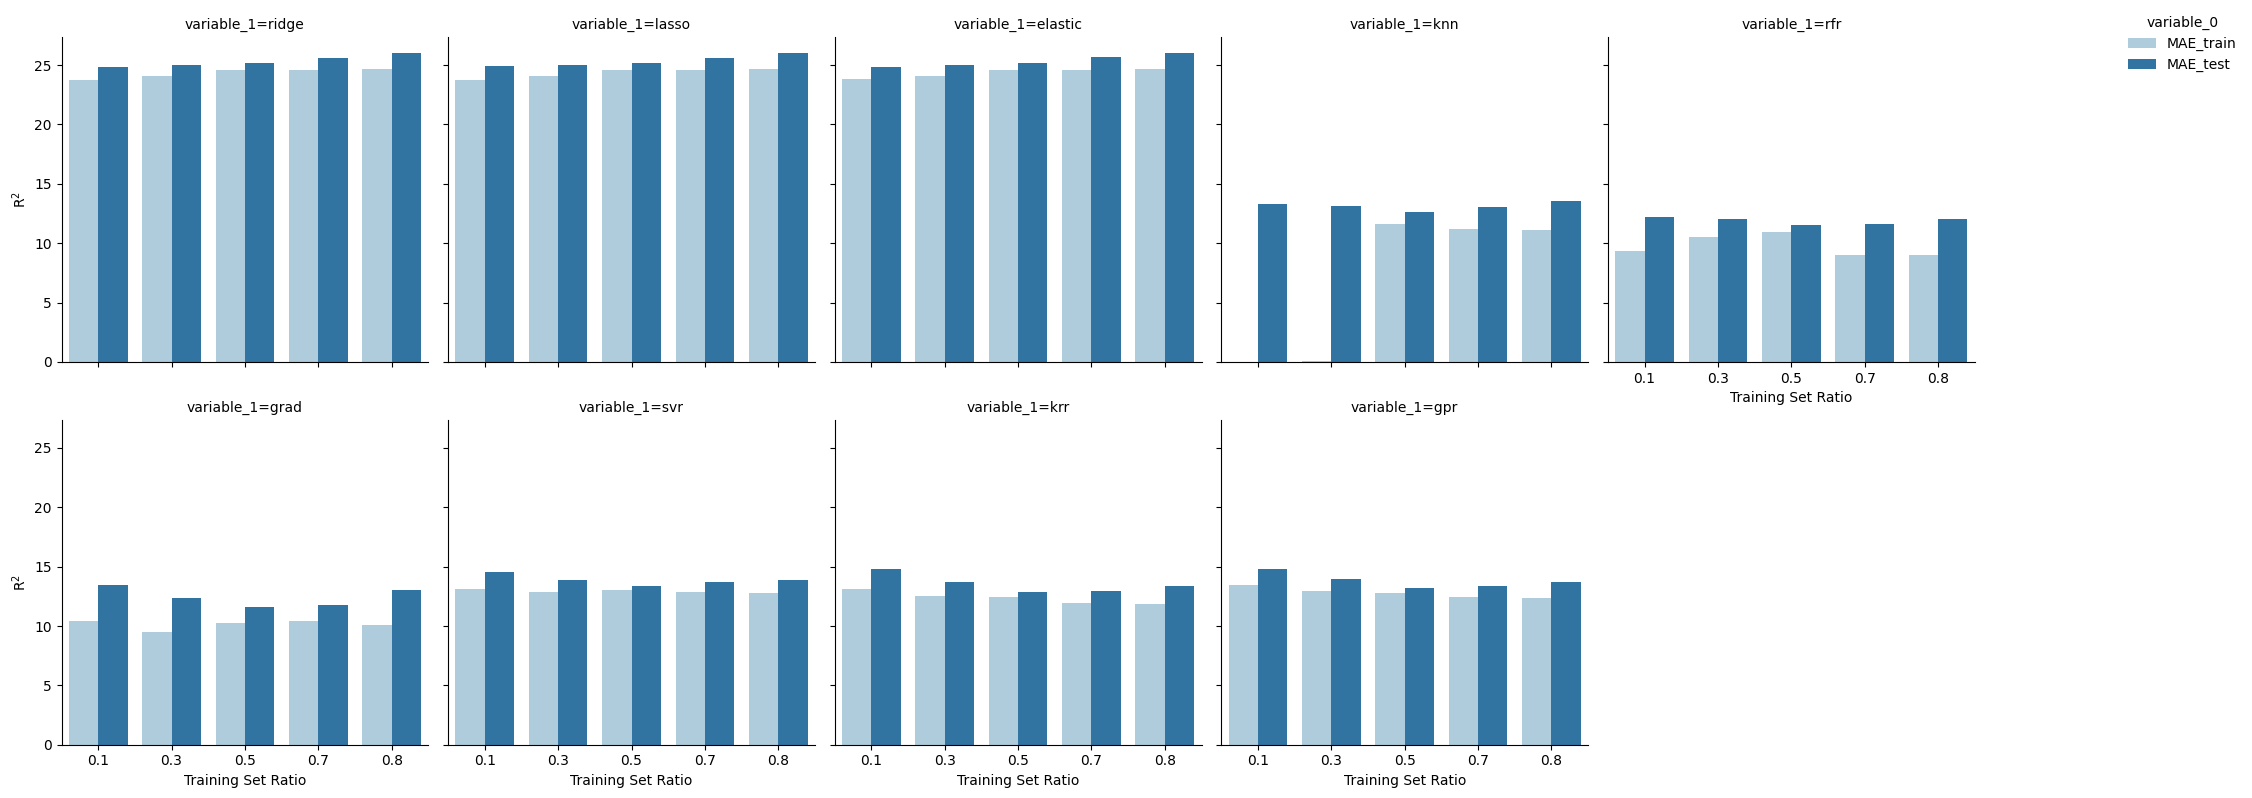

In [14]:
()

g=sns.catplot(
    dfmelt.reset_index(), kind="bar",
    x="index", y="value", col="variable_1", hue='variable_0',
    height=4, aspect=1, col_wrap=5,palette=sns.color_palette("Paired",2)
)
g.set_axis_labels("Training Set Ratio", "R$^{2}$")
g.set_titles("{col_var}={col_name}")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# g.set(ylim=(0, 1))